# MLP Model

Pre-Processing much of this has been done already and explained in the training notebook.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler    
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import skorch
from skorch import NeuralNetClassifier, NeuralNetBinaryClassifier
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import pickle


In [2]:
ccd = pd.read_csv(r'UCI_Credit_Card.csv')

ccd.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Check for null values

In [3]:
ccd.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

Drop ID column as it is not needed.

In [4]:
ccd = ccd.drop('ID', axis=1)
#ccd = ccd.drop(index=0, axis=2)

ccd.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Scale the data between 0 and 1

In [5]:
from sklearn.preprocessing import MinMaxScaler

inputs = ccd.drop('default.payment.next.month', axis=1)  # Drop the 'target' from the inputs.

# Scale only columns that have values greater than 1
to_scale = [col for col in inputs.columns if inputs[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(inputs[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

# Replace original columns with scaled ones
for col in scaled:
    inputs[col] = scaled[col]
    
inputs

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.010101,1.0,0.333333,0.333333,0.051724,0.4,0.4,0.1,0.1,0.0,...,0.086723,0.160138,0.080648,0.260979,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000
1,0.111111,1.0,0.333333,0.666667,0.086207,0.1,0.4,0.2,0.2,0.2,...,0.087817,0.163220,0.084074,0.263485,0.000000,0.000594,0.001116,0.001610,0.000000,0.003783
2,0.080808,1.0,0.333333,0.666667,0.224138,0.2,0.2,0.2,0.2,0.2,...,0.093789,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458
3,0.040404,1.0,0.333333,0.333333,0.275862,0.2,0.2,0.2,0.2,0.2,...,0.113407,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892
4,0.040404,0.0,0.333333,0.333333,0.620690,0.1,0.2,0.1,0.2,0.2,...,0.106020,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.212121,0.0,0.500000,0.333333,0.310345,0.2,0.2,0.2,0.2,0.2,...,0.200746,0.243036,0.111622,0.273259,0.009730,0.011875,0.005583,0.004907,0.011723,0.001892
29996,0.141414,0.0,0.500000,0.666667,0.379310,0.1,0.1,0.1,0.1,0.2,...,0.088267,0.168596,0.085794,0.260979,0.002103,0.002094,0.010042,0.000208,0.000000,0.000000
29997,0.020202,0.0,0.333333,0.666667,0.275862,0.6,0.5,0.4,0.1,0.2,...,0.087859,0.179805,0.101057,0.275854,0.000000,0.000000,0.024552,0.006763,0.004689,0.005864
29998,0.070707,0.0,0.500000,0.333333,0.344828,0.3,0.1,0.2,0.2,0.2,...,0.128239,0.209850,0.092403,0.298591,0.098334,0.002024,0.001315,0.003101,0.124174,0.003412


In [6]:
inputs = inputs.values

inputs.shape

(30000, 23)

In [7]:
outputs = ccd['default.payment.next.month']

In [8]:
outputs = outputs.values

outputs.shape

(30000,)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.25, random_state=42, stratify = outputs )

In [10]:
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype = torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype = torch.float)

## SMOTE

Balance the training data

In [11]:
sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X_train, y_train)                                                         #only apply smote to the training data for valid result

print(f'''Shape of inputs before SMOTE: {X_train.shape}
Shape of inputs after SMOTE: {X_sm.shape}''')

print(f'''\nShape of outputs before SMOTE: {y_train.shape}
Shape of outputs after SMOTE: {y_sm.shape}''')

print('\nBalance of positive and negative classes for outputs before SMOTE:')

unique, counts = np.unique(y_train, return_counts=True)

print(dict(zip(unique, counts)))

print('\nBalance of positive and negative classes for outputs after SMOTE:')

#y_sm.value_counts(normalize=True)*100

unique, counts = np.unique(y_sm, return_counts=True)

print(dict(zip(unique, counts)))

Shape of inputs before SMOTE: torch.Size([22500, 23])
Shape of inputs after SMOTE: (35046, 23)

Shape of outputs before SMOTE: torch.Size([22500])
Shape of outputs after SMOTE: (35046,)

Balance of positive and negative classes for outputs before SMOTE:
{0.0: 17523, 1.0: 4977}

Balance of positive and negative classes for outputs after SMOTE:
{0.0: 17523, 1.0: 17523}


In [12]:
X_sm = torch.tensor(X_sm, dtype=torch.float)
y_sm = torch.tensor(y_sm, dtype = torch.float)

In [13]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()        
        self.layer_1 = nn.Linear(23, 26) # Input layer
        self.layer_2 = nn.Linear(26, 26) # Hidden Layer
        self.layer_out = nn.Linear(26, 1) # Ouput Layer 
        
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)         # 0.1 = no dropout
        self.batchnorm1 = nn.BatchNorm1d(26)
        self.batchnorm2 = nn.BatchNorm1d(26)        
        

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


C:\Users\Marlon\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [15]:
model = binaryClassification()
model.to(device)
print(model) 

binaryClassification(
  (layer_1): Linear(in_features=23, out_features=26, bias=True)
  (layer_2): Linear(in_features=26, out_features=26, bias=True)
  (layer_out): Linear(in_features=26, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [16]:
torch.manual_seed(0)


net = NeuralNetBinaryClassifier(
    model,
    max_epochs=50, 
    lr= 0.01,
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping()],    
    optimizer__momentum = 0.6,
    device=device,
)

## Load trained model using pickle

In [17]:
# load the model from disk
filename = 'final_mlp_model.pkl'
mlp_model = pickle.load(open(filename, 'rb'))
result = mlp_model.score(X_sm, y_sm)
print(result)

0.7070707070707071


In [18]:
mlp_model

<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=binaryClassification(
    (layer_1): Linear(in_features=23, out_features=26, bias=True)
    (layer_2): Linear(in_features=26, out_features=26, bias=True)
    (layer_out): Linear(in_features=26, out_features=1, bias=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.1, inplace=False)
    (batchnorm1): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm2): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  ),
)

In [19]:
result = mlp_model.score(X_sm, y_sm)
print(result)

0.7070707070707071


In [20]:
y_pred = mlp_model.predict(X_test)

In [21]:
accuracy_score(y_test, y_pred)

0.7356

In [22]:
cm = confusion_matrix(y_test, y_pred)

cm

array([[4509, 1332],
       [ 651, 1008]], dtype=int64)

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.77      0.82      5841
         1.0       0.43      0.61      0.50      1659

    accuracy                           0.74      7500
   macro avg       0.65      0.69      0.66      7500
weighted avg       0.78      0.74      0.75      7500



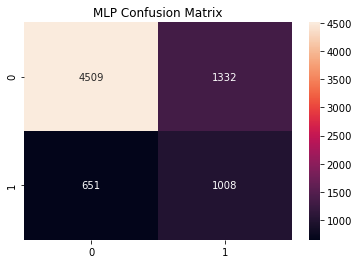

In [24]:
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='g')
ax.set_title('MLP Confusion Matrix')
plt.show()

In [25]:
y_pred_prob = mlp_model.predict_proba(X_test)

In [26]:
nodef_prob = y_pred_prob[::,0]
def_prob = y_pred_prob[::,1]

In [27]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, nodef_prob)
fpr2, tpr2, thresholds2 = roc_curve(y_test, def_prob)

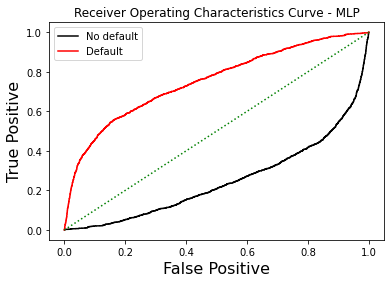

In [28]:
plt.plot(fpr, tpr, color='black' ,label = 'No default')
plt.plot(fpr2, tpr2, color='red', label = 'Default')
plt.title('Receiver Operating Characteristics Curve - MLP')
plt.plot([0,1], [0,1], color = 'green', linestyle=':')
plt.xlabel('False Positive', size=16)
plt.ylabel('True Positive', size=16)
plt.legend()
plt.show()

In [29]:
# calculate AUC
auc1 = roc_auc_score(y_test, nodef_prob)
auc2 = roc_auc_score(y_test, def_prob)
print('AUC: %.3f' % auc1)
print('AUC: %.3f' % auc2)

AUC: 0.249
AUC: 0.751


### Preceision recall curve

In [30]:
# Precision Recall Curve
from sklearn.metrics import precision_recall_curve

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, nodef_prob)
precision2, recall2, thresholds2 = precision_recall_curve(y_test, def_prob)

In [31]:
# calculate precision-recall AUC
from sklearn.metrics import auc

auc1 = auc(recall, precision)
auc2 = auc(recall2, precision2)

print(auc1)
print(auc2)

0.14452565240249124
0.5158345989911063


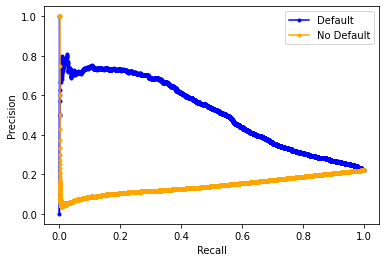

In [32]:
# plot the precision-recall curves
plt.plot(recall2,precision2, marker='.', color = 'blue' ,label='Default')
plt.plot(recall, precision, marker='.', color = 'orange' ,label='No Default')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

# SVM Model

## Pre-Processing

In [33]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler    
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import skorch
from skorch import NeuralNetClassifier, NeuralNetBinaryClassifier
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [34]:
ccd = pd.read_csv(r'UCI_Credit_Card.csv')

ccd.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [35]:
ccd.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [36]:
ccd = ccd.drop('ID', axis=1)
#ccd = ccd.drop(index=0, axis=2)

ccd.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Scale the data between 0 and 1

In [37]:
from sklearn.preprocessing import MinMaxScaler

inputs = ccd.drop('default.payment.next.month', axis=1)  # Drop the 'target' from the inputs.

# Scale only columns that have values greater than 1
to_scale = [col for col in inputs.columns if inputs[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(inputs[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

# Replace original columns with scaled ones
for col in scaled:
    inputs[col] = scaled[col]
    
inputs

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.010101,1.0,0.333333,0.333333,0.051724,0.4,0.4,0.1,0.1,0.0,...,0.086723,0.160138,0.080648,0.260979,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000
1,0.111111,1.0,0.333333,0.666667,0.086207,0.1,0.4,0.2,0.2,0.2,...,0.087817,0.163220,0.084074,0.263485,0.000000,0.000594,0.001116,0.001610,0.000000,0.003783
2,0.080808,1.0,0.333333,0.666667,0.224138,0.2,0.2,0.2,0.2,0.2,...,0.093789,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458
3,0.040404,1.0,0.333333,0.333333,0.275862,0.2,0.2,0.2,0.2,0.2,...,0.113407,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892
4,0.040404,0.0,0.333333,0.333333,0.620690,0.1,0.2,0.1,0.2,0.2,...,0.106020,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.212121,0.0,0.500000,0.333333,0.310345,0.2,0.2,0.2,0.2,0.2,...,0.200746,0.243036,0.111622,0.273259,0.009730,0.011875,0.005583,0.004907,0.011723,0.001892
29996,0.141414,0.0,0.500000,0.666667,0.379310,0.1,0.1,0.1,0.1,0.2,...,0.088267,0.168596,0.085794,0.260979,0.002103,0.002094,0.010042,0.000208,0.000000,0.000000
29997,0.020202,0.0,0.333333,0.666667,0.275862,0.6,0.5,0.4,0.1,0.2,...,0.087859,0.179805,0.101057,0.275854,0.000000,0.000000,0.024552,0.006763,0.004689,0.005864
29998,0.070707,0.0,0.500000,0.333333,0.344828,0.3,0.1,0.2,0.2,0.2,...,0.128239,0.209850,0.092403,0.298591,0.098334,0.002024,0.001315,0.003101,0.124174,0.003412


In [38]:
inputs = inputs.values

inputs.shape

(30000, 23)

In [39]:
outputs = ccd['default.payment.next.month']

In [40]:
outputs = outputs.values

outputs.shape

(30000,)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.25, random_state=42, stratify = outputs )

SMOTE - Balance the data

In [42]:
sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X_train, y_train)                                                         #only apply smote to the training data for valid result

print(f'''Shape of inputs before SMOTE: {X_train.shape}
Shape of inputs after SMOTE: {X_sm.shape}''')

print(f'''\nShape of outputs before SMOTE: {y_train.shape}
Shape of outputs after SMOTE: {y_sm.shape}''')

print('\nBalance of positive and negative classes for outputs before SMOTE:')

unique, counts = np.unique(y_train, return_counts=True)

print(dict(zip(unique, counts)))

print('\nBalance of positive and negative classes for outputs after SMOTE:')

#y_sm.value_counts(normalize=True)*100

unique, counts = np.unique(y_sm, return_counts=True)

print(dict(zip(unique, counts)))

Shape of inputs before SMOTE: (22500, 23)
Shape of inputs after SMOTE: (35046, 23)

Shape of outputs before SMOTE: (22500,)
Shape of outputs after SMOTE: (35046,)

Balance of positive and negative classes for outputs before SMOTE:
{0: 17523, 1: 4977}

Balance of positive and negative classes for outputs after SMOTE:
{0: 17523, 1: 17523}


In [43]:
#Create the SVM model
# {'C': 100, 'degree': 4, 'kernel': 'poly'}
from sklearn.svm import SVC
classifier = SVC(kernel = 'poly', random_state = 0, C=100, degree=4, probability=True)#, cache_size= 2000)#, max_iter=50000, class_weight="balanced")


#classifier.fit(X_sm, y_sm)

#Make the prediction
#y_pred = classifier.predict(X_test)

## Save trained model using pickle

In [44]:
# save to local drive
#filename = 'final_svm_model.pkl'
#with open(filename, 'wb') as file:
#    pickle.dump(classifier, file)

## Load trained model using pickle

In [45]:
# load the model from disk
filename = 'final_svm_model.pkl'
svm_model = pickle.load(open(filename, 'rb'))
result = svm_model.score(X_sm, y_sm)
print(result)

0.7382582891057468


In [46]:
svm_model

SVC(C=100, degree=4, kernel='poly', probability=True, random_state=0)

In [47]:
y_pred = svm_model.predict(X_test)

In [48]:
accuracy_score(y_test, y_pred)

0.7706666666666667

In [49]:
cm = confusion_matrix(y_test, y_pred)

cm

array([[4866,  975],
       [ 745,  914]], dtype=int64)

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      5841
           1       0.48      0.55      0.52      1659

    accuracy                           0.77      7500
   macro avg       0.68      0.69      0.68      7500
weighted avg       0.78      0.77      0.78      7500



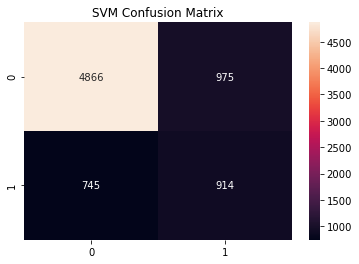

In [51]:
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='g')
ax.set_title('SVM Confusion Matrix')
plt.show()

In [52]:
y_pred_prob = svm_model.predict_proba(X_test)

In [53]:
nodef_prob = y_pred_prob[::,0]
def_prob = y_pred_prob[::,1]

In [54]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, nodef_prob)
fpr2, tpr2, thresholds2 = roc_curve(y_test, def_prob)

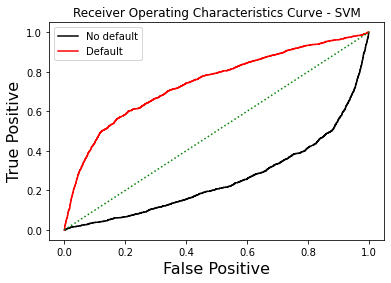

In [55]:
plt.plot(fpr, tpr, color='black' ,label = 'No default')
plt.plot(fpr2, tpr2, color='red', label = 'Default')
plt.title('Receiver Operating Characteristics Curve - SVM')
plt.plot([0,1], [0,1], color = 'green', linestyle=':')
plt.xlabel('False Positive', size=16)
plt.ylabel('True Positive', size=16)
plt.legend()
plt.show()

In [56]:
# calculate AUC
auc1 = roc_auc_score(y_test, nodef_prob)
auc2 = roc_auc_score(y_test, def_prob)
print('AUC: %.3f' % auc1)
print('AUC: %.3f' % auc2)

AUC: 0.258
AUC: 0.742


### Precision recall curve

In [57]:
# Precision Recall Curve
from sklearn.metrics import precision_recall_curve

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, nodef_prob)
precision2, recall2, thresholds2 = precision_recall_curve(y_test, def_prob)

In [58]:
# calculate F1 score
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred)
f1

0.5152198421645997

In [59]:
# calculate precision-recall AUC
from sklearn.metrics import auc

auc1 = auc(recall, precision)
auc2 = auc(recall2, precision2)

print(auc1)
print(auc2)

0.1467930211705789
0.4910110873467453


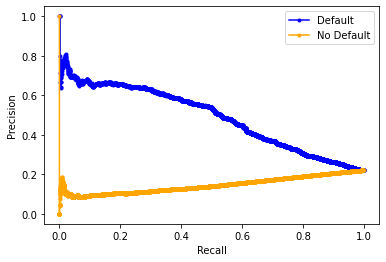

In [60]:
# plot the precision-recall curves
plt.plot(recall2,precision2, marker='.', color = 'blue' ,label='Default')
plt.plot(recall, precision, marker='.', color = 'orange' ,label='No Default')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()